In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
from tensorflow.keras.metrics import MeanSquaredError

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Paths for training and test data
train_path = '/kaggle/input/nn-proj-dataset/traindata1.xlsx'
test_path = '/kaggle/input/nn-proj-dataset/testdata1.xlsx'

In [3]:
# Load training data
train_df = pd.read_excel(train_path)

# Extract Training values
X_train = train_df[['X', 'Y', 'Z']].values
y_train = train_df[['Rev1', 'Rev2', 'Rev3', 'Rev4', 'Rev5', 'Pris']].values
train_df.head()

,Rev1,Rev2,Rev3,Rev4,Rev5,Pris,X,Y,Z
0,-12,-20,-12,-20,78,7,42.469630,11.970936,53.556263
1,-12,-20,-12,-20,78,14,38.630023,17.131616,56.317567
2,-12,-20,-12,-20,86,0,44.888215,8.007522,45.606921
3,-12,-20,-12,-20,86,7,40.796781,13.380376,47.448826
4,-12,-20,-12,-20,86,14,36.705348,18.753230,49.290731


In [4]:
# Load test data
test_df = pd.read_excel(test_path)

# Extract Testing values
X_test = test_df[['X', 'Y', 'Z']].values
y_test = test_df[['Rev1', 'Rev2', 'Rev3', 'Rev4', 'Rev5', 'Pris']].values

In [5]:
# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [6]:
# K-Fold Cross-Validation
kf = KFold(n_splits=3)
mse= MeanSquaredError()

fold = 1
all_history = []
all_test_loss = []

In [7]:
for train_index, val_index in kf.split(X_scaled):
    print(f"Training on Fold {fold}")
    fold += 1

    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y_scaled[train_index], y_scaled[val_index]

    # Build the neural network using TensorFlow
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_fold.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6)
    ])

    # Compile the model with a different learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model on the fold
    history = model.fit(
        X_train_fold, y_train_fold, 
        epochs=50, 
        batch_size=16, 
        validation_data=(X_val_fold, y_val_fold)
    )

    all_history.append(history)

Training on Fold 1
Epoch 1/50
167/167 [==============================] - 4s 6ms/step - loss: 1.6961 - val_loss: 0.2251
Epoch 2/50
167/167 [==============================] - 1s 5ms/step - loss: 0.8970 - val_loss: 0.1799
Epoch 3/50
167/167 [==============================] - 1s 5ms/step - loss: 0.5880 - val_loss: 0.1166
Epoch 4/50
167/167 [==============================] - 1s 5ms/step - loss: 0.4287 - val_loss: 0.0884
Epoch 5/50
167/167 [==============================] - 1s 5ms/step - loss: 0.3229 - val_loss: 0.0906
Epoch 6/50
167/167 [==============================] - 1s 5ms/step - loss: 0.2587 - val_loss: 0.0805
Epoch 7/50
167/167 [==============================] - 1s 5ms/step - loss: 0.2063 - val_loss: 0.0782
Epoch 8/50
167/167 [==============================] - 1s 5ms/step - loss: 0.1700 - val_loss: 0.0782
Epoch 9/50
167/167 [==============================] - 1s 5ms/step - loss: 0.1415 - val_loss: 0.0761
Epoch 10/50
167/167 [==============================] - 1s 5ms/step - loss: 0.1218

In [8]:
# Evaluate the model to get the default loss
test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.20388172566890717


In [9]:
# Predictions on the test set
test_predictions = model.predict(X_test_scaled)


32/32 [==============================] - 0s 1ms/step


In [10]:
# Calculate the average of the outputs
average_outputs = test_predictions.mean(axis=0)
print("Average Outputs:", average_outputs)

Average Outputs: [-5.8150282e-22  2.6521075e-01  5.7754874e-01  3.1568515e-01
  4.8714054e-01  5.8441269e-01]


In [11]:
# Update the state of the MSE metric
mse.update_state(y_test_scaled, test_predictions)

# Calculate the MSE
test_mse = mse.result().numpy()
print(f'Test MSE: {test_mse}')

Test MSE: 0.20388175547122955


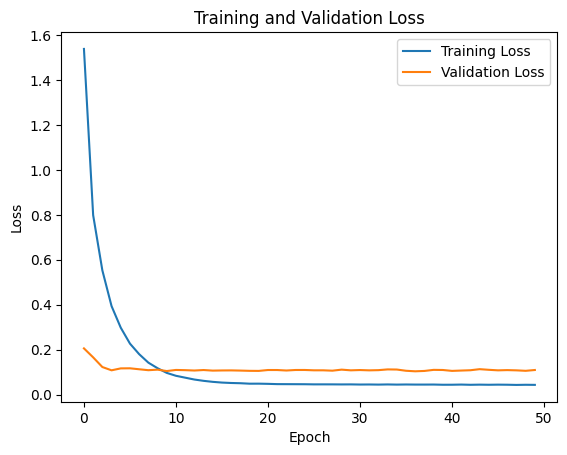

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

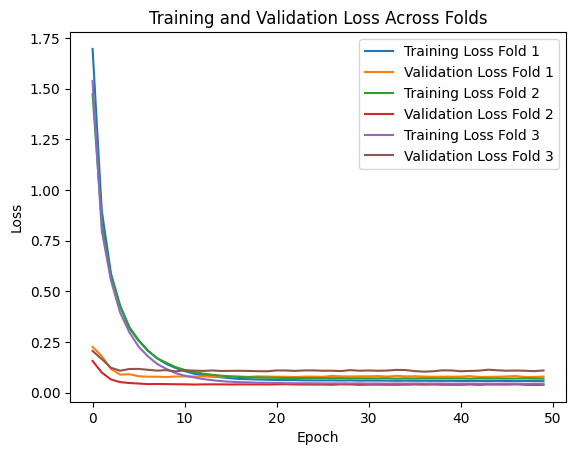

In [13]:
# Plotting the training and validation loss
for i, history in enumerate(all_history):
    plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')

plt.title('Training and Validation Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

32/32 [==============================] - 0s 2ms/step - loss: 0.2039


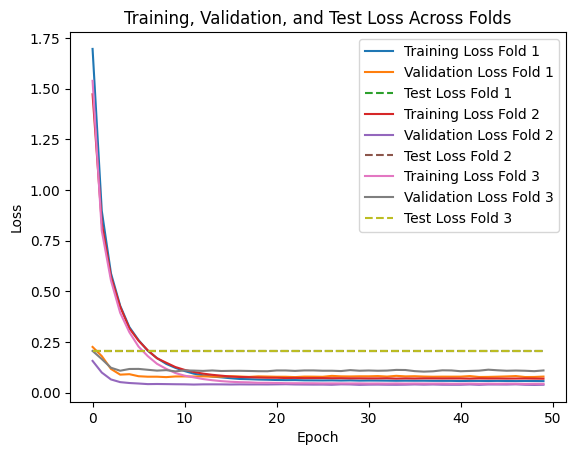

In [14]:
  # Evaluate the model on the test set and store the test loss
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
all_test_loss.append(test_loss)

# Plotting the training, validation, and test loss
for i, history in enumerate(all_history):
    plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
    plt.plot([test_loss for _ in history.history['loss']], label=f'Test Loss Fold {i+1}', linestyle='--')

plt.title('Training, Validation, and Test Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()